### DSAI Mini Project - Personal Key Indicators of Heart Disease

In [6]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report,plot_roc_curve,plot_precision_recall_curve
from sklearn.model_selection import train_test_split,cross_val_predict
sb.set()

### Welcome to our model on the key indicators of heart disease! 

#### We will be attempting to establish a model that can successfully predict if an individual will have a cardiac episode based off several factors.

#### There are 3 types of inputs:
- Objective: Factual information;
- Examination: Results of medical examination;
- Subjective: Information given by the patient.

#### Factors:
- Age | Objective Feature | age | int (days)
- Height | Objective Feature | height | int (cm) |
- Weight | Objective Feature | weight | float (kg) |
- Gender | Objective Feature | gender | categorical code |
- Systolic blood pressure | Examination Feature | ap_hi | int |
- Diastolic blood pressure | Examination Feature | ap_lo | int |
- Cholesterol | Examination Feature | cholesterol | 1: normal, 2: above normal, 3: well above normal |
- Glucose | Examination Feature | gluc | 1: normal, 2: above normal, 3: well above normal |
- Smoking | Subjective Feature | smoke | binary |
- Alcohol intake | Subjective Feature | alco | binary |
- Physical activity | Subjective Feature | active | binary |
- Presence or absence of cardiovascular disease | Target Variable | cardio | binary |

##### It should be noted that all these dataset values were collected at the moment of medical examination, thereby promoting credibility

#### Before we continue, there are some terms that need to be explained and some commonly understood assumptions that we will attempt to verify through the following data

#### Explanations:

- Cardiovascular Disease: Disease of the heart or blood vessels that results in reduced blood flow to vital organs in the human body.
- Systolic Blood Pressure: Pressure exerted when blood is ejected from the heart and into the arteries
- Diastolic Blood Pressure: Pressure that blood exerts within the arteries and in between heartbeats
- Cholesterol: Constituent of cell membranes that is necessary for a body to function but an increased proportion in the body is associated with higher risk of cardiovascular disease


#### Assumptions:
- The increase in age results in an increase in the chance of heart disease
- The increase in cholesterol increaases the chance of heart disease
- Smoking + Drinking habits increases the chance of heart disease

#### The first step is to import the dataset and clean the data by removing duplicates

In [7]:
heart = pd.read_csv('C:/Users/Varun/Desktop/cardio_train.csv')
heart.head()

ID    Age  Gender  Height  Weight  ap_hi  ap_lo  Cholesterol  Gluc  Smoke  \
0   0  18393       2     168    62.0    110     80            1     1      0   
1   1  20228       1     156    85.0    140     90            3     1      0   
2   2  18857       1     165    64.0    130     70            3     1      0   
3   3  17623       2     169    82.0    150    100            1     1      0   
4   4  17474       1     156    56.0    100     60            1     1      0   

   Alco  Active  Cardio  
0     0       1       0  
1     0       1       1  
2     0       0       1  
3     0       1       1  
4     0       0       0

In [8]:
heartdata = pd.DataFrame(heart)
heartdata.info()

# Data column IDs, total count and data type

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ID           70000 non-null  int64  
 1   Age          70000 non-null  int64  
 2   Gender       70000 non-null  int64  
 3   Height       70000 non-null  int64  
 4   Weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   Cholesterol  70000 non-null  int64  
 8   Gluc         70000 non-null  int64  
 9   Smoke        70000 non-null  int64  
 10  Alco         70000 non-null  int64  
 11  Active       70000 non-null  int64  
 12  Cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


In [9]:
# Remove duplicate datasets before continuing

duplicates = len(heartdata) - len(heartdata.drop(['ID'],axis=1).drop_duplicates())
heartdata.drop(['ID'],axis=1,inplace=True)
heartdata.drop_duplicates(inplace=True)

print(f'{duplicates} duplicate records dropped.')

#Show how the current data looks like after duplicates are dropped
heartdata.shape

24 duplicate records dropped.


(69976, 12)

In [10]:
# Insert separate rows for male and female and remove the generic 'gender' row
heartdata.insert(3, "Female", (heartdata['Gender']==1).astype(int))
heartdata.insert(4, 'Male', (heartdata['Gender']==2).astype(int))
heartdata.drop(['Gender'], axis=1, inplace=True)

# Change age from days to years

heartdata['Age'] = round(heartdata['Age']/365.25,2)

# Basic data characteristics such as count, mean, standard deviation and quartiles, rounded to 2 decimal places

heartdata.describe().T.round(2)

count    mean     std     min     25%     50%     75%       max
Age          69976.0   53.30    6.76   29.56   48.36   53.94   58.39     64.92
Height       69976.0  164.36    8.21   55.00  159.00  165.00  170.00    250.00
Female       69976.0    0.65    0.48    0.00    0.00    1.00    1.00      1.00
Male         69976.0    0.35    0.48    0.00    0.00    0.00    1.00      1.00
Weight       69976.0   74.21   14.40   10.00   65.00   72.00   82.00    200.00
ap_hi        69976.0  128.82  154.04 -150.00  120.00  120.00  140.00  16020.00
ap_lo        69976.0   96.64  188.50  -70.00   80.00   80.00   90.00  11000.00
Cholesterol  69976.0    1.37    0.68    1.00    1.00    1.00    2.00      3.00
Gluc         69976.0    1.23    0.57    1.00    1.00    1.00    1.00      3.00
Smoke        69976.0    0.09    0.28    0.00    0.00    0.00    0.00      1.00
Alco         69976.0    0.05    0.23    0.00    0.00    0.00    0.00      1.00
Active       69976.0    0.80    0.40    0.00    1.00    1.00    1.00      1.00
Cardio       69976.0    0.50    0.50    0.00    0.00    0.00    1.00      1.00

#### Now that the duplicates have been removed, we can start to identify outliers to clean the dataset.

#### Outliers would include values that are out of possible range or excessively skewed indicating a potential flawed reading

It can be clearly observed from the previous description of the data that the max and min data for height and weight represent values that are way off the height and weight spectrum, for example, individuals who are 250cm in height or individuals who weigh 10 kg.

However, in-order to make a current judgement for the removal of outliers, we should consider both these values together instead of looking at it separately

C:\Users\Varun\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Varun\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


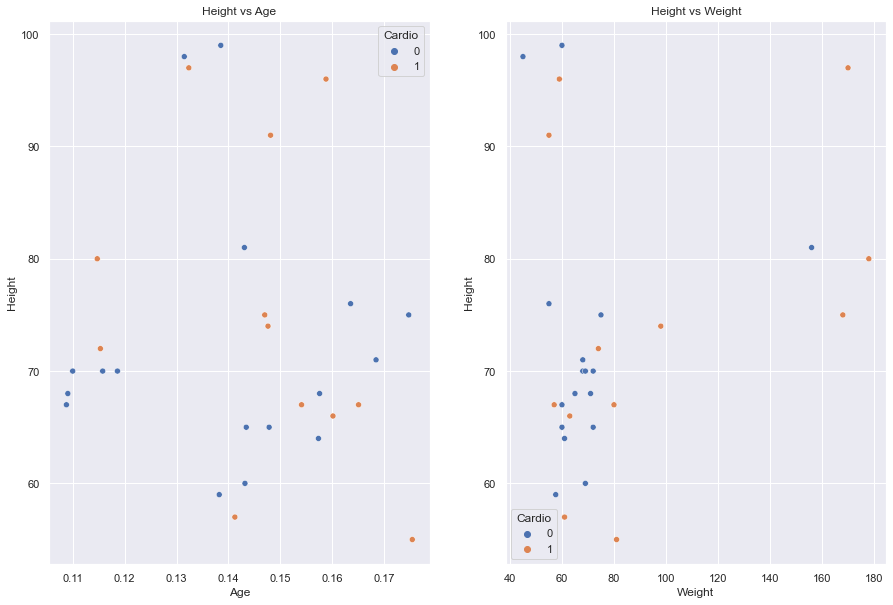

In [11]:
# To do so, we can view the data as a scatterplot to identify these potential outliers in a 2-Dimensional view
# Additionally, we can also compare these data points with the age of the respondents to see if they are very young children or much older adults

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,10))

sb.scatterplot(heartdata['Age']/365,heartdata['Height'][heartdata['Height']<100],hue=heartdata['Cardio'],ax=ax1)
ax1.set_title('Height vs Age')

sb.scatterplot(heartdata['Weight'],heartdata['Height'][heartdata['Height']<100],hue=heartdata['Cardio'],ax=ax2)
ax2.set_title('Height vs Weight')

plt.show()

From the above scatterplots, it is easy to see that for those who are below 100cm in height, they are aged above around 40 years old. Furthermore, some of them also weigh above 140kg which is highly unlikely. As such, it can be evaluated that these data point should be filtered out.

In [12]:
# Filter out these datasets

filter1 = (heartdata['Height'] > 195) | (heartdata['Height'] < 100)
outliers = list(heartdata[filter1].index)

heartdata.drop(index=outliers, inplace=True)

num_outliers_deleted = len(outliers)
print(f'{num_outliers_deleted} outliers due to incorrect height and weight have been deleted')
print(f'New shape of dataset: {heartdata.shape}')

56 outliers due to incorrect height and weight have been deleted
New shape of dataset: (69920, 13)


Next factor to consider when cleaning the dataset would be blood pressure indexes that are out of range. 

Based off health data, the following image reflects the different ranges of systolic and diastolic blood pressure:

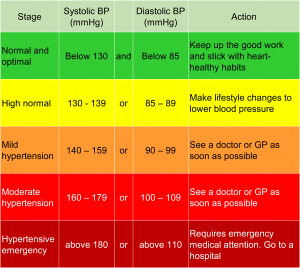


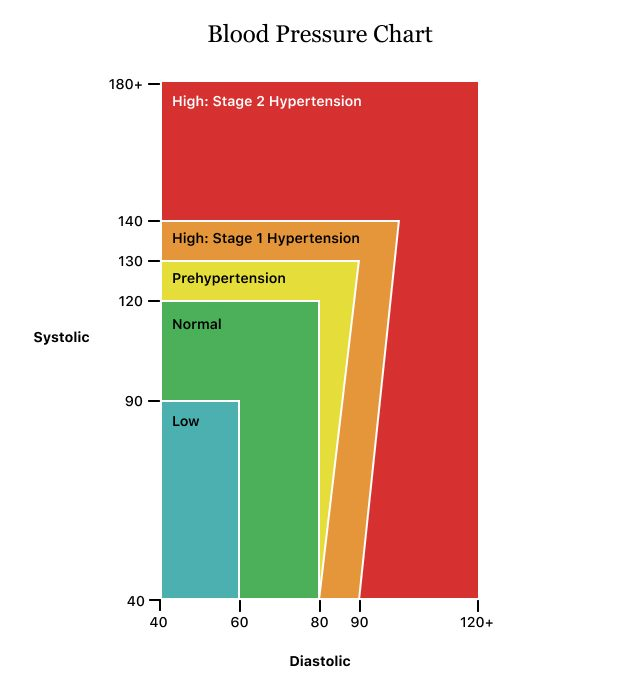

##### Accounting for minor variations, we can give a +/-10mmHg headroom for all the characteristics

Therefore, data above 200 mmHg for systolic or below 80mmHg and above 120 mmHg or below 50 for diastolic can be filtered out as outliers

In [13]:
# Filter out data based off the above characteristics

filter2 = (heartdata['ap_hi'] > 200) | (heartdata['ap_hi'] < 90) | (heartdata['ap_lo'] > 120) | (heartdata['ap_lo'] < 50)
outliers2 = list(heartdata[filter2].index)

heartdata.drop(index=outliers2, inplace=True)

num_outliers_deleted2 = len(outliers2)
print(f'{num_outliers_deleted2} outliers due to blood pressure have been deleted')
print(f'New shape of dataset: {heartdata.shape}')

1493 outliers due to blood pressure have been deleted
New shape of dataset: (68427, 13)


In [14]:
# Basic data characteristics after the removal of outliers

heartdata.describe().T.round(2)

count    mean    std     min     25%     50%     75%     max
Age          68427.0   53.29   6.76   29.56   48.34   53.94   58.38   64.92
Height       68427.0  164.39   7.95  100.00  159.00  165.00  170.00  195.00
Female       68427.0    0.65   0.48    0.00    0.00    1.00    1.00    1.00
Male         68427.0    0.35   0.48    0.00    0.00    0.00    1.00    1.00
Weight       68427.0   74.11  14.29   11.00   65.00   72.00   82.00  200.00
ap_hi        68427.0  126.63  16.40   90.00  120.00  120.00  140.00  200.00
ap_lo        68427.0   81.29   9.27   50.00   80.00   80.00   90.00  120.00
Cholesterol  68427.0    1.36   0.68    1.00    1.00    1.00    1.00    3.00
Gluc         68427.0    1.23   0.57    1.00    1.00    1.00    1.00    3.00
Smoke        68427.0    0.09   0.28    0.00    0.00    0.00    0.00    1.00
Alco         68427.0    0.05   0.22    0.00    0.00    0.00    0.00    1.00
Active       68427.0    0.80   0.40    0.00    1.00    1.00    1.00    1.00
Cardio       68427.0    0.49   0.50    0.00    0.00    0.00    1.00    1.00

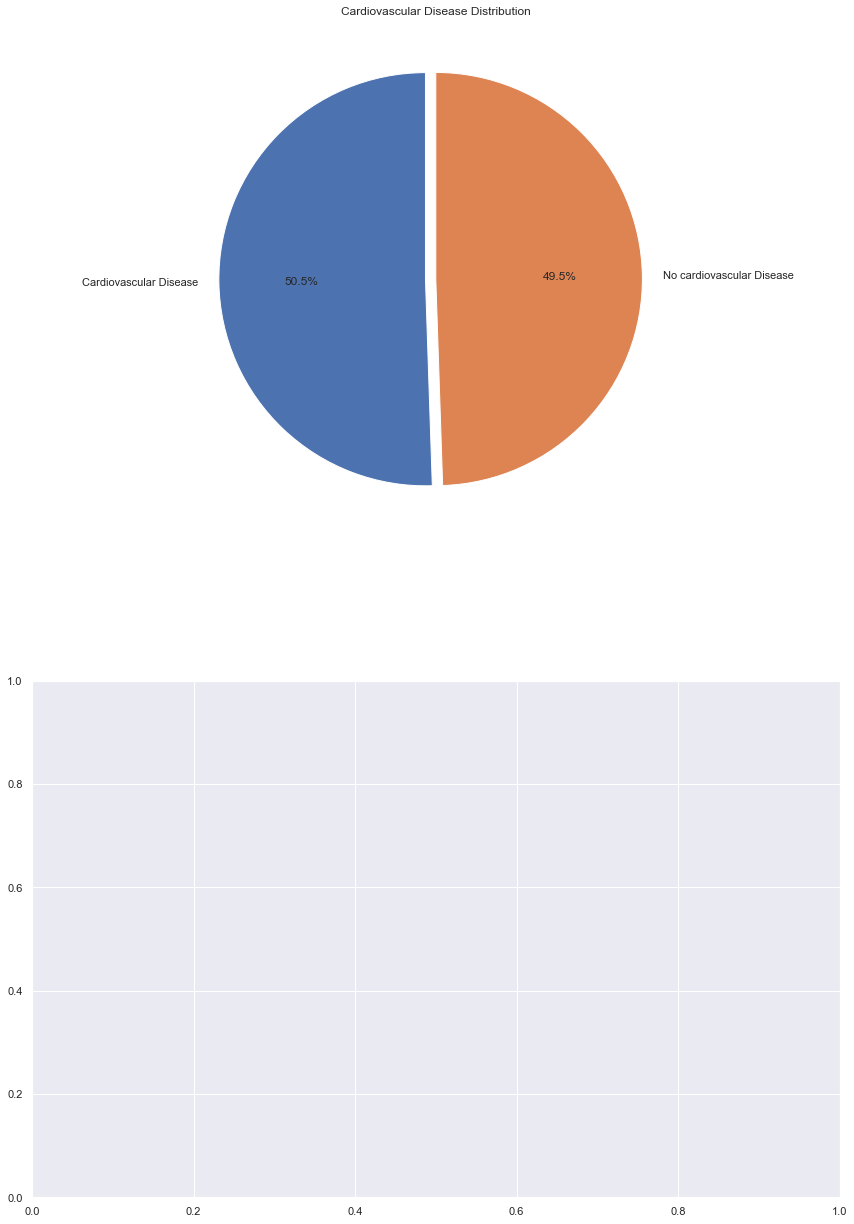

In [21]:
fig, ax = plt.subplots(2, figsize=(15,20))
plt.tight_layout(pad=10)
ax[0].pie(x=heartdata['Cardio'].value_counts(), labels=['Cardiovascular Disease', 'No cardiovascular Disease'],autopct='%1.1f%%', shadow=False, startangle=90, explode=(0.05,0.0))
ax[0].title.set_text('Cardiovascular Disease Distribution')

From this, we are able to identify certain key features:

- Mean age of patients: 19464.9/365 = 53 years and 3 months old
- Ratio of males to females - 35:65
- Mean height - 164.39cm
- Mean weight - 74.11kg
- Mean systolic blood pressure - 126.63
- Mean diastolic blood pressure - 81.29
- Percentage of smokers - 9%
- Percentage of alcoholics - 5%
- Percentage of participants who engage in sport activities - 80%
- Percentage of participants who have cardiovascular disease - 49%

Interestingly, the percentage of participants who have cardiovascular disease is exactly half as compared to participants who do not have cardiovascular disease. This is useful for the machine learning segment that will come later as it reduces the potential of classification bias.